Data Set 1 for the BCI Competition IV

In [1]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import mne

In [2]:
dat = loadmat('BCICIV_calib_ds1d.mat', struct_as_record=True)

In [3]:
dat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])

In [4]:
sfreq = dat['nfo']['fs'][0][0][0][0]
EEGdata   = dat['cnt'].T
nchannels, nsamples = EEGdata.shape

chan_names = [s[0] for s in dat['nfo']['clab'][0][0][0]]

event_onsets  = dat['mrk'][0][0][0]
event_codes   = dat['mrk'][0][0][1]

labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in dat['nfo']['classes'][0][0][0]]
cl1    = cl_lab[0]
cl2    = cl_lab[1]

xpos = dat['nfo']['xpos']
ypos = dat['nfo']['ypos']

nclasses = len(cl_lab)
nevents = len(event_onsets)


print('Shape of EEG:', EEGdata.shape)
print('Sample rate:', sfreq)
print('Number of channels:', nchannels)
print('Channel names:', chan_names)
print('Number of events:', len(event_onsets))
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)

Shape of EEG: (59, 190473)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events: 1
Event codes: [-1  1]
Class labels: ['left', 'right']
Number of classes: 2


In [5]:

trials = {}

# The time window to extract for each trial, here 0.5 -- 2.5 seconds
win = np.arange(int(0.5*sfreq), int(2.5*sfreq))
nsamples = len(win)

for cl, code in zip(cl_lab, np.unique(event_codes)):

    cl_onsets = event_onsets[event_codes == code]

    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))

    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEGdata[:, win+onset]

print('Shape of trials[cl1]:', trials[cl1].shape)
print('Shape of trials[cl2]:', trials[cl2].shape)

Shape of trials[cl1]: (59, 200, 100)
Shape of trials[cl2]: (59, 200, 100)


In [7]:
left_hand  = np.rollaxis(trials[cl1], 2, 0)
right_hand = np.rollaxis(trials[cl2], 2, 0)

In [8]:
left_hand.shape

(100, 59, 200)

In [9]:
data = np.concatenate([left_hand, right_hand])

In [10]:
# create labels
Y = np.concatenate([-np.ones(left_hand.shape[0]),
                     np.ones(right_hand.shape[0])])

In [12]:
n_channels = 59
info = mne.create_info(
        ch_names = chan_names,
        ch_types = ['eeg']*nchannels,
        sfreq    = sfreq )

print('Event created :', info)

Event created : <Info | 7 non-empty values
 bads: []
 ch_names: AF3, AF4, F5, F3, F1, Fz, F2, F4, F6, FC5, FC3, FC1, FCz, FC2, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 100.0 Hz
>


In [13]:
xpos = dat['nfo']['xpos'][0][0]
ypos = dat['nfo']['ypos'][0][0]

In [14]:
layout_pos = np.concatenate([xpos, ypos], axis = 1)
layout_pos

array([[-0.20109028,  0.68656518],
       [ 0.20109028,  0.68656518],
       [-0.48547489,  0.52547424],
       [-0.32894737,  0.46520183],
       [-0.16535231,  0.43208641],
       [ 0.        ,  0.421549  ],
       [ 0.16535231,  0.43208641],
       [ 0.32894737,  0.46520183],
       [ 0.48547489,  0.52547424],
       [-0.60591541,  0.27165704],
       [-0.39919579,  0.23384348],
       [-0.19765935,  0.21394494],
       [ 0.        ,  0.20773757],
       [ 0.19765935,  0.21394494],
       [ 0.39919579,  0.23384348],
       [ 0.60591541,  0.27165704],
       [-0.74834683,  0.15177169],
       [-0.52472976,  0.12553103],
       [-0.30963911,  0.11086096],
       [-0.10226303,  0.10426648],
       [ 0.10226303,  0.10426648],
       [ 0.30963911,  0.11086096],
       [ 0.52472976,  0.12553103],
       [ 0.74834683,  0.15177169],
       [-0.87719298,  0.        ],
       [-0.64569058,  0.        ],
       [-0.421549  ,  0.        ],
       [-0.20773757,  0.        ],
       [ 0.        ,

In [15]:
layout = mne.channels.generate_2d_layout(
    xy = layout_pos,
    ch_names=chan_names,
    name ='EEG custom layout',
    )

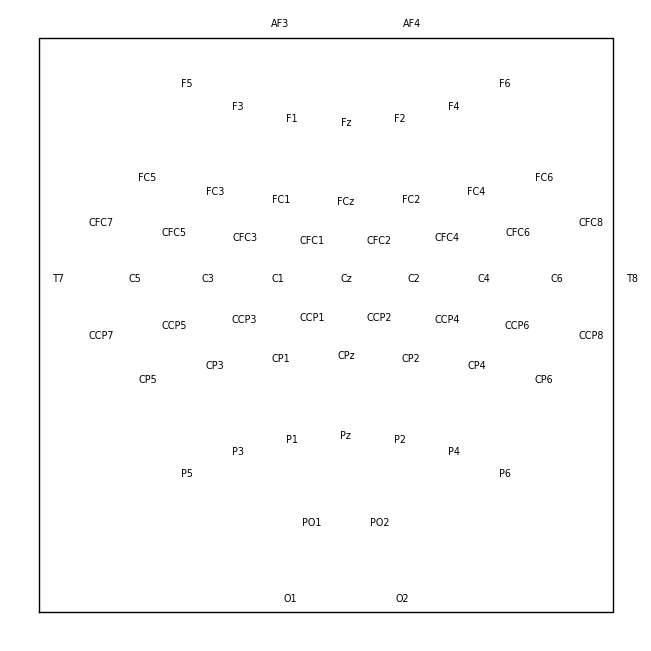

In [16]:
layout.plot();

In [17]:
event_id = dict(left = -1, right = 1)

In [18]:
eventLength = Y.shape[0]
ev = [i*sfreq*3 for i in range(eventLength)]

events = np.column_stack((np.array(ev,  dtype = int),
                          np.zeros(eventLength,  dtype = int),
                          np.array(Y,  dtype = int)))

In [19]:
events

array([[    0,     0,    -1],
       [  300,     0,    -1],
       [  600,     0,    -1],
       [  900,     0,    -1],
       [ 1200,     0,    -1],
       [ 1500,     0,    -1],
       [ 1800,     0,    -1],
       [ 2100,     0,    -1],
       [ 2400,     0,    -1],
       [ 2700,     0,    -1],
       [ 3000,     0,    -1],
       [ 3300,     0,    -1],
       [ 3600,     0,    -1],
       [ 3900,     0,    -1],
       [ 4200,     0,    -1],
       [ 4500,     0,    -1],
       [ 4800,     0,    -1],
       [ 5100,     0,    -1],
       [ 5400,     0,    -1],
       [ 5700,     0,    -1],
       [ 6000,     0,    -1],
       [ 6300,     0,    -1],
       [ 6600,     0,    -1],
       [ 6900,     0,    -1],
       [ 7200,     0,    -1],
       [ 7500,     0,    -1],
       [ 7800,     0,    -1],
       [ 8100,     0,    -1],
       [ 8400,     0,    -1],
       [ 8700,     0,    -1],
       [ 9000,     0,    -1],
       [ 9300,     0,    -1],
       [ 9600,     0,    -1],
       [ 9

In [20]:
# The time window (in samples) to extract for each trial, here 0.5 -- 2.5 seconds
tmin = 0.5
epochs = mne.EpochsArray(data, info, events, tmin, event_id)

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


In [21]:
epochs.get_data().shape

(200, 59, 200)

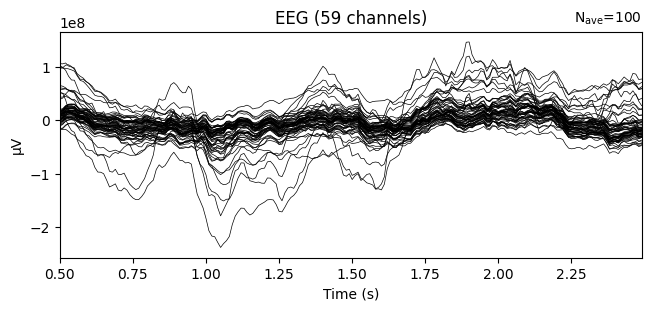

In [22]:
epochs['left'].average().plot();

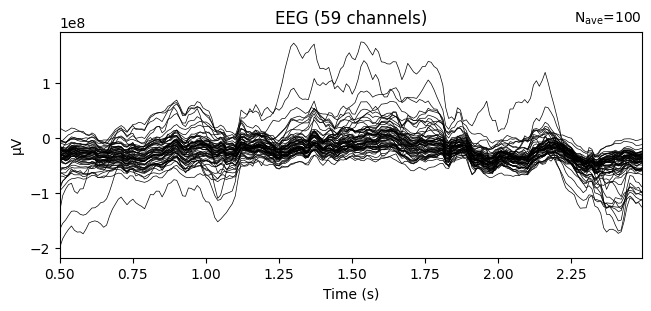

In [23]:
epochs['right'].average().plot();

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


C:\Users\Greatest Pleasure\AppData\Local\Temp\ipykernel_11324\2204970765.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd();
C:\Users\Greatest Pleasure\AppData\Roaming\Python\Python312\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


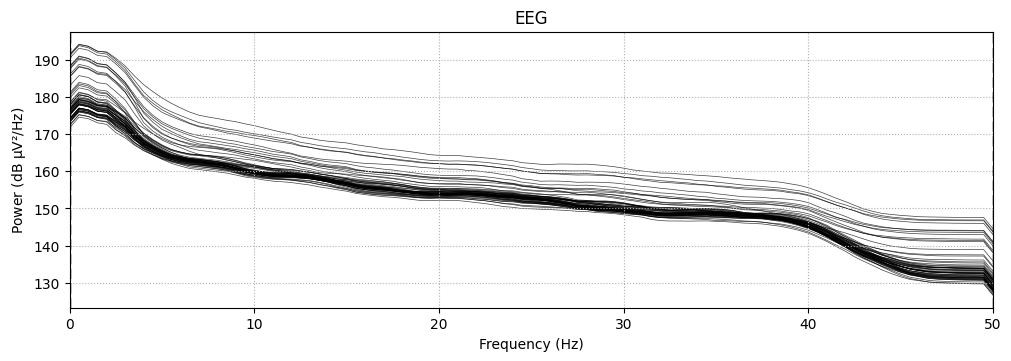

In [24]:
epochs.plot_psd();

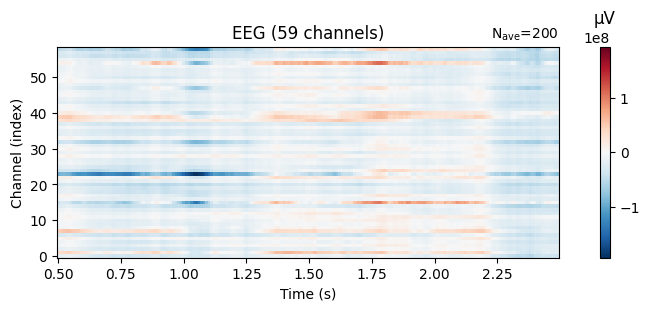

In [25]:
epochs.average().plot_image();

In [26]:
epochs.filter(l_freq=8, h_freq=32)

Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.7s
[Parallel(n_job

<EpochsArray | 200 events (all good), 0.5 – 2.49 s (baseline off), ~18.1 MB, data loaded,
 'left': 100
 'right': 100>

In [28]:
from scipy.signal import welch
import numpy as np
def compute_psd(eeg_data, frequency_range, fs=100, nperseg=50):
    epochs, channels, _ = eeg_data.shape
    psd = np.zeros((epochs, channels))

    for epoch in range(epochs):
        for channel in range(channels):
            freqs, power_spectrum = welch(eeg_data[epoch, channel], fs=fs, nperseg=nperseg)
            freq_min, freq_max = frequency_range
            indices = np.logical_and(freqs >= freq_min, freqs <= freq_max)
            psd[epoch, channel] = np.mean(power_spectrum[indices])

    return psd

frequency_bands = {
    #'delta': (1, 4),
    #'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (13, 30)
}

def extract_band_features(eeg_data, bands, fs=100, nperseg=50):
    features = []
    for band_name, freq_range in bands.items():
        psd_band = compute_psd(eeg_data, frequency_range=freq_range, fs=fs, nperseg=nperseg)
        features.append(psd_band)
    return np.hstack(features)

X = epochs.get_data() 
X_features = extract_band_features(X, frequency_bands)

In [29]:
X_features.shape


(200, 118)

In [30]:
y = epochs.events[:, -1]
y.shape

(200,)

In [36]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

features = X_features 
label_array = y

X_train, X_test, y_train, y_test = train_test_split(features, label_array, test_size=0.2, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Random Forest Classifier
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('classifier', RandomForestClassifier(random_state=0))
])
rf_params = {
        'classifier__n_estimators': [10,15, 30],
        'classifier__max_depth': [3, 6, 9,12],
        'classifier__max_features': ['sqrt', 0.3],
        'classifier__min_samples_split': [5, 10],
        'classifier__min_samples_leaf': [2, 4,6]
}
rf_grid = GridSearchCV(rf_pipe, rf_params, cv=kf)
rf_grid.fit(X_train, y_train)
rf_best_model = rf_grid.best_estimator_

y_pred_rf = rf_best_model.predict(X_test)
print("\nRandom Forest Model Performance:")
print(f"Training Accuracy: {rf_best_model.score(X_train, y_train):.2f}")
print(f"Test Accuracy: {rf_best_model.score(X_test, y_test):.2f}")
print(classification_report(y_test, y_pred_rf))



Random Forest Model Performance:
Training Accuracy: 0.98
Test Accuracy: 0.57
              precision    recall  f1-score   support

          -1       0.62      0.48      0.54        21
           1       0.54      0.68      0.60        19

    accuracy                           0.57        40
   macro avg       0.58      0.58      0.57        40
weighted avg       0.59      0.57      0.57        40



C:\Users\Greatest Pleasure\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [32]:
# Gradient Boosting Classifier
gb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('classifier', GradientBoostingClassifier())
])
gb_params = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5]  
}
gb_grid = GridSearchCV(gb_pipe, gb_params, cv=kf)
gb_grid.fit(X_train, y_train)
gb_best_model = gb_grid.best_estimator_

y_pred_gb = gb_best_model.predict(X_test)
print("\nGradient Boosting Model Performance:")
print(f"Training Accuracy: {gb_best_model.score(X_train, y_train):.2f}")
print(f"Test Accuracy: {gb_best_model.score(X_test, y_test):.2f}")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Model Performance:
Training Accuracy: 1.00
Test Accuracy: 0.72
              precision    recall  f1-score   support

          -1       0.75      0.71      0.73        21
           1       0.70      0.74      0.72        19

    accuracy                           0.72        40
   macro avg       0.72      0.73      0.72        40
weighted avg       0.73      0.72      0.73        40



In [48]:
# Multilayer perceptron
mlp_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('classifier', MLPClassifier(max_iter=300, random_state=2))
])
mlp_params = {
        'classifier__hidden_layer_sizes': [(60,), (100,), (50, 50), (50, 100)],  # Expand hidden layers
         'classifier__alpha': [0.001, 0.01, 0.1, 0.3,0.5]
}
mlp_grid = GridSearchCV(mlp_pipe, mlp_params, cv=kf)
mlp_grid.fit(X_train, y_train)
mlp_best_model = mlp_grid.best_estimator_

y_pred_mlp = mlp_best_model.predict(X_test)
print("\nMLP Model Performance:")
print(f"Training Accuracy: {mlp_best_model.score(X_train, y_train):.2f}")
print(f"Test Accuracy: {mlp_best_model.score(X_test, y_test):.2f}")
print(classification_report(y_test, y_pred_mlp))

C:\Users\Greatest Pleasure\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Greatest Pleasure\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Greatest Pleasure\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Greatest Pleasure\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the 


MLP Model Performance:
Training Accuracy: 0.99
Test Accuracy: 0.60
              precision    recall  f1-score   support

          -1       0.63      0.57      0.60        21
           1       0.57      0.63      0.60        19

    accuracy                           0.60        40
   macro avg       0.60      0.60      0.60        40
weighted avg       0.60      0.60      0.60        40



C:\Users\Greatest Pleasure\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [51]:
from mne.decoding import CSP
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

csp = CSP(n_components=4, reg=None, log=True) 
svc = SVC(kernel='linear')

pipe = Pipeline([
    ('csp', csp),
    ('scaler', StandardScaler()),
    ('classifier', svc)
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))


Computing rank from data with rank=None
    Using tolerance 6.2e+02 (2.2e-16 eps * 59 dim * 4.8e+16  max singular value)
    Estimated rank (data): 59
    data: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
              precision    recall  f1-score   support

          -1       0.90      0.90      0.90        21
           1       0.89      0.89      0.89        19

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



In [52]:
print(f"Training Accuracy: {pipe.score(X_train, y_train):.2f}")
print(f"Test Accuracy: {pipe.score(X_test, y_test):.2f}")

Training Accuracy: 0.97
Test Accuracy: 0.90
